# Analyza nejistot minimalizace EMM - random gener

In [1]:
# Setup some Jupyter env features
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
# plot dat
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import rcParams

rcParams["font.size"] = 16
rcParams["mathtext.fontset"] = "cm"
rcParams["mathtext.rm"] = "serif"
rcParams["text.usetex"] = "true";
rc('text', usetex=True)

Nejprve načtu histogramy odpovídající jednotlivým měřením

In [2]:
import numpy as np


# fotkor_z = np.genfromtxt("axial_EMM_10_03_2020_part2_delim.txt", delimiter="\t")[:,1]
# voltages_z = np.genfromtxt("axial_EMM_10_03_2020_part2_voltages.txt", delimiter="\t")[1,:]
# fotkor_xz = np.genfromtxt("sikmy_EMM_10_03_2020_part1_delim.txt", delimiter="\t")[:,5]
# voltages_xz = np.genfromtxt("sikmy_EMM_10_03_2020_part1_voltages.txt", delimiter="\t")[5,:]

# nacteni dat pouze v minimu EMM
fotkor_z = np.genfromtxt("03_05_20_EMM_min_z_final_delim.txt", delimiter="\t")[:,0]
voltages_z = np.genfromtxt("03_05_20_EMM_min_z_final_voltages.txt", delimiter="\t")[0,:]
fotkor_xz = np.genfromtxt("03_05_20_EMM_min_xz_multiple_delim.txt", delimiter="\t")[:,6]
voltages_xz = np.genfromtxt("03_05_20_EMM_min_xz_multiple_voltages.txt", delimiter="\t")[6,:]

# pomocne promene
fotkor_z_shape = np.shape(fotkor_z)
fotkor_xz_shape = np.shape(fotkor_xz)
# dale predpokladam, ze signaly maji stejny pocet binu
# fotkor_shape = np.array( [fotkor_z_shape, fotkor_xz_shape] )

# parametry odecitani foton-korelacnich dat
t_res = 256e-12  # casove rozliseni histogramu v s
t_measure = [100, 85] # doba nacitani dat v s

# casova skala foton-kor. dat
t_scale_z = np.array( range(0,fotkor_z_shape[0]) ) *t_res
t_scale_xz = np.array( range(0,fotkor_xz_shape[0]) ) *t_res

t_scale = t_scale_z

background_photocounts = [190, 130] # ph/s  tyto fotony jsou rovnomerne rozdeleny v prubehu RF periody
#---------- odecet pozadi v ose z
bg_ph_sum = background_photocounts[0] * t_measure[0]  # celkovy pocet fotonu pozadi za cas mereni

last_bin_ratio_z = fotkor_z[fotkor_z_shape[0]-2] / fotkor_z[fotkor_z_shape[0]-3]  # pomer mezi county v poslednim/predposlednim binu
bg_ph_per_bin_z = bg_ph_sum/(fotkor_z_shape[0]-2 + last_bin_ratio_z)

fotkor_z[:fotkor_z_shape[0]-2] = fotkor_z[:fotkor_z_shape[0]-2] - bg_ph_per_bin_z 
fotkor_z[fotkor_z_shape[0]-2] = fotkor_z[fotkor_z_shape[0]-2] - bg_ph_per_bin_z * last_bin_ratio_z
#--------------------
#--------- odecet pozadi v ose xz
bg_ph_sum = background_photocounts[1] * t_measure[1]  # celkovy pocet fotonu pozadi za cas mereni
last_bin_ratio_xz = fotkor_xz[fotkor_xz_shape[0]-2] / fotkor_xz[fotkor_xz_shape[0]-3]  # pomer mezi county v poslednim/predposlednim binu
bg_ph_per_bin_xz = bg_ph_sum/(fotkor_xz_shape[0]-2 + last_bin_ratio_xz)

fotkor_xz[:fotkor_xz_shape[0]-2] = fotkor_xz[:fotkor_xz_shape[0]-2] - bg_ph_per_bin_xz 
fotkor_xz[fotkor_xz_shape[0]-2] = fotkor_xz[fotkor_xz_shape[0]-2] - bg_ph_per_bin_xz * last_bin_ratio_xz
# ------------------------------
#----------- odecet pozadi v ose xy

#----------------------------------

# vlozim signaly a voltage do matic
fotkor = np.transpose( np.array( [fotkor_z, fotkor_xz] ) ) # tvar: [data, osa]
voltages = np.transpose( np.array( [voltages_z, voltages_xz] ) ) # tvar: [data, osa]

fotkor_shape = np.shape(fotkor)

# celkovy pocet detekovanych fotonu
photon_sum = np.sum(fotkor, axis=0)
photon_sum

array([313002., 293578.])

In [3]:
# odhad periody triggeru
Omega = np.zeros(fotkor_shape[1])
Omega_sigma = np.zeros(fotkor_shape[1])

for i in range(fotkor_shape[1]):
    T_trig = ( fotkor[fotkor_shape[0]-2,i] / fotkor[fotkor_shape[0]-3,i] )* t_res + t_scale[fotkor_shape[0]-2]
    T_trig_sigma = t_res
    # frekvence buzeni pasti

    drive_freq = 1/T_trig
    drive_freq_sigma = 1/T_trig**2 *T_trig_sigma
    Omega[i] = 2*np.pi * drive_freq
    Omega_sigma[i] = 2*np.pi * drive_freq_sigma
    print(drive_freq)
    
Omega = np.mean(Omega)
Omega_sigma = np.sqrt(0.5*np.sum(Omega_sigma**2) )

print(Omega/(2*np.pi))
print(Omega_sigma/(2*np.pi))

30036150.75204228
30037521.471918117
30036836.111980196
230966.15040694075


Fitovani histogramu

In [4]:
# residua vcetne vah
# funkce vracejici residua
def fit_resid_weight(x,W_vec, Omega, S, time_step):
    # x = [S_0, Delta S, phi]
    # W_vec .. vektor vah prislusejicich jednotlivym bodum
    len_S = len(S)
    #print(len_S)
    S_fit = x[0] + x[1] * np.cos(Omega * time_step * np.arange(0, len_S) + x[2])
    return( np.sqrt(W_vec) * (S - S_fit) )

def fit_func(x, Omega, time_points):
    return x[0] + x[1] * np.cos(Omega * time_points + x[2])

def fit_resid(x, Omega, S, time_step):
    # x = [S_0, Delta S, phi]
    len_S = len(S)
    #print(len_S)
    S_fit = x[0] + x[1] * np.cos(Omega * time_step * np.arange(0, len_S) + x[2])
    return S - S_fit

Vygeneruju data dle predpokladanych varianci bodu histogramu

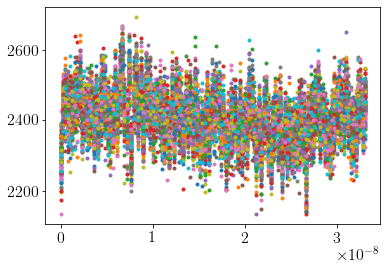

In [10]:
# generace nahodnych bodu dle zadanych dat 
N = 100
plt.figure()
for k in range(N):
    hist_sigma = [50, 50]   # sigma dat histogramu pro [x, xz]
    fotkor_rand = np.random.normal(fotkor, hist_sigma)
    
    
    plt.plot(t_scale[:fotkor_shape[0]-2], fotkor_rand[:fotkor_shape[0]-2, 0], '.')

generace funguje v poradku

In [11]:
from scipy.optimize import least_squares
# cyklus fitujici vsechny foton-korelacni data


N = 10000 # pocet nahodnych generaci

DeltaS_S_rand = np.zeros( (N, fotkor_shape[1]) )
fot_phi_rand = np.zeros( (N, fotkor_shape[1]) )
# x_rand = np.zeros((N, fotkor_shape[1],3))

hist_sigma = 0.09088658 * np.sqrt( photon_sum ) # sigma binu jednotlivych fotkor-signalu
# hist_sigma = [86, 110]   # sigma dat histogramu pro [x, xz]
for k in range(N):
    
    #----- generace nahodnych bodu dle namerenych histogramu
    fotkor_rand = np.random.normal(fotkor, hist_sigma)
    #------
    
    #-------- fit nahodne vygenerovanych dat
    x = np.zeros( (3,fotkor_shape[1]) )
    DeltaS_S_ratio = []
    fot_phi = []
    
    # cyklus fituje data z matice fotkor_rand
    for i in range(fotkor_shape[1]):
        x0 = [fotkor_rand[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor_rand[:fotkor_shape[0]-2,i].max()
            -fotkor_rand[:fotkor_shape[0]-2,i].min() ), 1.5]


        #fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
        fit = least_squares(fit_resid,x0, args=(Omega, fotkor_rand[:fotkor_shape[0]-2,i], t_res) , ftol=1e-10, xtol=1e-10)



        x[:,i] = fit.x
        DeltaS_S_ratio.append(x[1,i]/x[0,i]  )

        #---- faze fot-kor signalu
        fot_phi.append( np.angle(DeltaS_S_ratio[i]*np.exp(1j*x[2,i])) )
    #--------
    
    # po nafitovani ulozim zjistene hodnoty
    DeltaS_S_rand[k, :] = np.abs(DeltaS_S_ratio)
    fot_phi_rand[k,:] = fot_phi
#     x_rand[k,:,:] = np.transpose(x)
    
    
#------- vypocet prumerne hodnoty + std odchylky
DeltaS_S_mean = np.mean( DeltaS_S_rand , axis=0) # prumer
DeltaS_S_std = np.std( DeltaS_S_rand, axis=0)  # std
fot_phi_mean = np.mean( fot_phi_rand, axis=0 ) # prumer
fot_phi_std = np.std( fot_phi_rand, axis=0 )  # std



In [12]:
print(DeltaS_S_mean)
print(DeltaS_S_std)

print(fot_phi_mean)
print(fot_phi_std)

[0.01454123 0.00739136]
[0.00260445 0.0025957 ]
[-1.1331367  -2.08638303]
[0.18765584 0.83692127]


vizualni kontrola

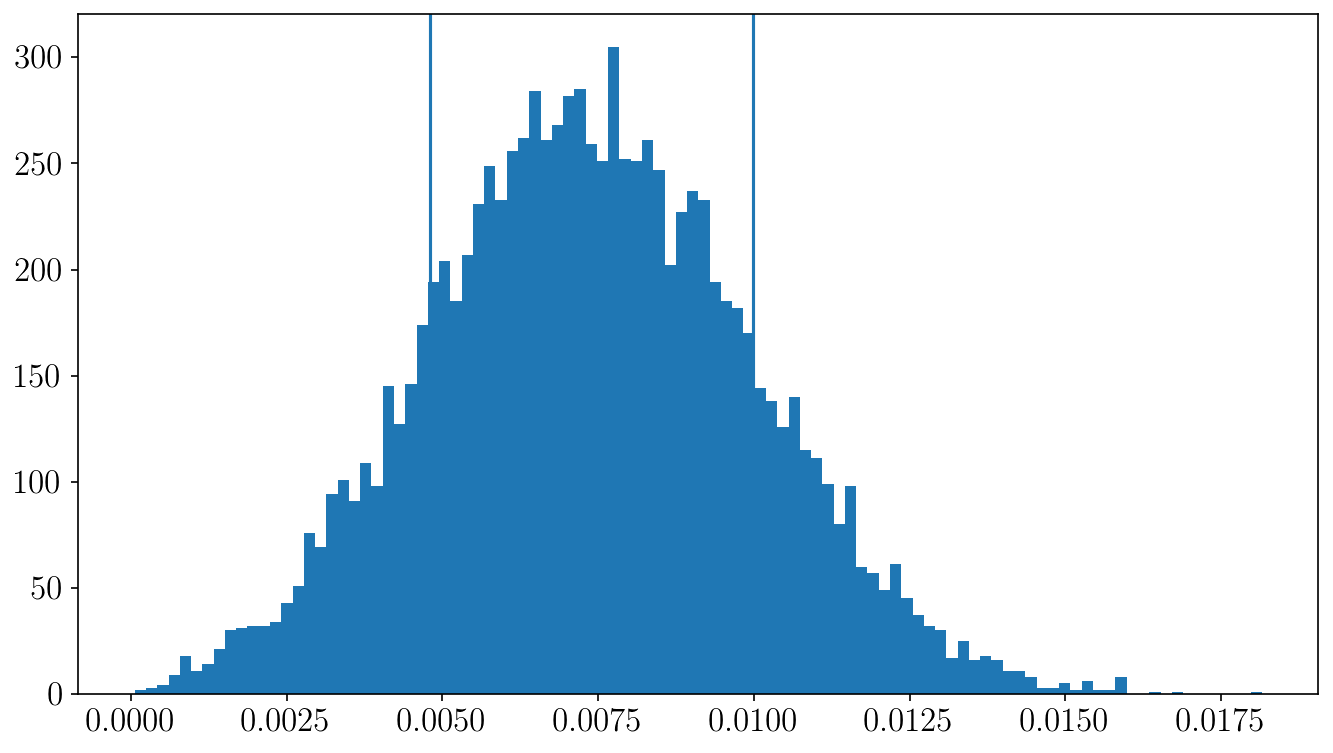

In [15]:
# histogram DeltaS_S

my_dpi = 150
siz = 100
sizex = 16*siz
sizey = 9*siz
#plot techto fitu


plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.hist(DeltaS_S_rand[:,1], bins=100, density=False);
plt.axvline(DeltaS_S_mean[1] - DeltaS_S_std[1])
plt.axvline(DeltaS_S_mean[1] + DeltaS_S_std[1])

ok, ted znam Delta_S/S a jeho rozlozeni, zkusis spocitat bety s tím, ze budu samplovat ostatni parametry

In [16]:
# parametry vypoctu beta

decay_rate = 2*np.pi * 21.008e6  # decay rate dle tabulek NISTu
laser_detun = -32e6 * 2*np.pi  # detuning 
laser_detun_sigma = 4e6 * 2*np.pi # sigma detun
# Omega_sigma=0

In [17]:
# numericke reseni deltaS/S -> beta

from scipy.optimize import fsolve
from scipy.special import j0, j1

def get_A(decay_rate, detun):
    # returns driven oscillator amplitude in point given by detun param.
    return 1 / 2 * (decay_rate / 2 - detun * 1j) / (detun ** 2 + (decay_rate / 2) ** 2)

def fl_signal(beta, laser_detun, Omega, decay_rate):
    # function calculates deltaS/S0 photon-correlation signal
    # input: beta, laser detuning, RF drive freq, decay rate
    A_minus = get_A(decay_rate, laser_detun - Omega)
    A_plus = get_A(decay_rate, laser_detun + Omega)
    A = get_A(decay_rate, laser_detun)

    numer = 2 * j0(beta) * j1(beta) * np.abs(np.conj(A) * A_plus - A * np.conj(A_minus))
    denom = j0(beta) ** 2 * np.abs(A) ** 2 + j1(beta) ** 2 * (np.abs(A_plus) ** 2 + np.abs(A_minus) ** 2)

    return numer / denom

def get_beta(Omega, decay_rate, laser_detun, norm_mod_amp):
    # function calculates the corresponding beta for given known parameters
    # input: drive frequency, decay_rate, laser detuning, normalized modulation amplitude given by ph_corr_signal
    # output: float value of beta
    def root_func(beta, laser_detun, Omega, decay_rate, norm_mod_amp):
        return fl_signal(beta, laser_detun, Omega, decay_rate) - norm_mod_amp

    sol = fsolve(root_func, np.array([0.01]), args=(laser_detun, Omega, decay_rate, norm_mod_amp), full_output=1)
    return float(sol[0])

In [18]:
np.random.normal(Omega, Omega_sigma)

189883211.66645977

In [19]:
from scipy.stats import rv_histogram
# get beta
beta_rand = np.zeros(np.shape(DeltaS_S_rand))

for k in range(np.shape(DeltaS_S_rand)[1]):
    
    for i in range(np.shape(DeltaS_S_rand)[0]):
        Omega_rand = np.random.normal(Omega, Omega_sigma)
        laser_detun_rand = np.random.normal(laser_detun, laser_detun_sigma)
        beta_rand[i,k] = get_beta(Omega_rand, decay_rate, laser_detun_rand, DeltaS_S_rand[i,k])
        
#------- vypocet prumerne hodnoty + std odchylky
beta_mean = np.mean( beta_rand , axis=0) # prumer
beta_std = np.std( beta_rand, axis=0)  # std  



In [22]:
#------- zkusim spocitat nejistotu pomoci skutecneho rozdeleni
hist_beta = np.histogram(beta_rand[:,1], bins=150)
hist_beta_dist = rv_histogram(hist_beta)
print(hist_beta_dist.median())
print( np.mean( np.abs(hist_beta_dist.median() - hist_beta_dist.interval(0.67) ) ) )
hist_beta_dist.interval(0.67)

0.002723380590304753
0.0009703926634180355


(0.0017892642268995532, 0.0037300495537356242)

In [23]:
print(beta_mean)
print(beta_std)

[0.00543871 0.00276365]
[0.00110182 0.0010055 ]


In [24]:
print(beta_mean)
print(beta_std)

[0.00543871 0.00276365]
[0.00110182 0.0010055 ]


jeste nad tim zapremyslet

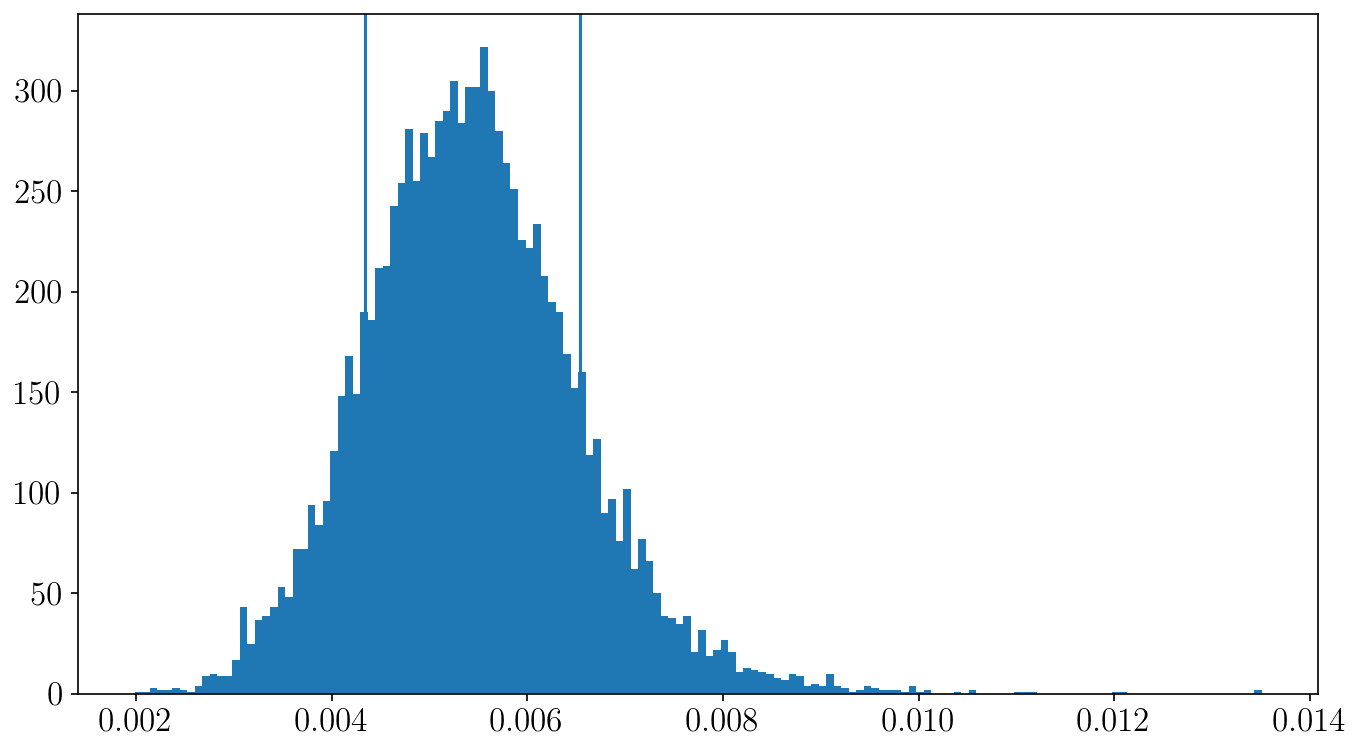

In [25]:
# histogram beta

my_dpi = 150
siz = 100
sizex = 16*siz
sizey = 9*siz
#plot techto fitu


plt.figure(figsize=(sizex/my_dpi, sizey/my_dpi), dpi=my_dpi)
plt.hist(beta_rand[:,0], bins=150, density=False);
plt.axvline(beta_mean[0] - beta_std[0])
plt.axvline(beta_mean[0] + beta_std[0])

In [26]:
from scipy.optimize import least_squares
# cyklus fitujici vsechny foton-korelacni data


N = 1000 # pocet nahodnych generaci

DeltaS_S_rand = np.zeros( (N, fotkor_shape[1]) )
fot_phi_rand = np.zeros( (N, fotkor_shape[1]) )
x_rand = np.zeros((N, fotkor_shape[1],3))
fotkor_rand_save = np.zeros((N,fotkor_shape[0], fotkor_shape[1]))

hist_sigma = [80, 100]   # sigma dat histogramu pro [x, xz]
for k in range(N):
    
    #----- generace nahodnych bodu dle namerenych histogramu
    fotkor_rand = np.random.normal(fotkor, hist_sigma)
    fotkor_rand_save[k, :,:] = fotkor_rand
    #------
    
    #-------- fit nahodne vygenerovanych dat
    x = np.zeros( (3,fotkor_shape[1]) )
    DeltaS_S_ratio = []
    fot_phi = []
    
    # cyklus fituje data z matice fotkor_rand
    for i in range(fotkor_shape[1]):
        x0 = [fotkor_rand[:fotkor_shape[0]-2,i].mean(), 0.5* ( fotkor_rand[:fotkor_shape[0]-2,i].max()
            -fotkor_rand[:fotkor_shape[0]-2,i].min() ), -1.5]


        #fit = least_squares(fit_resid,x0, args=(Omega, fotkor_bezcond[:fotkor_shape[0]-2,0], t_res) , method="lm", ftol=1e-10)
        fit = least_squares(fit_resid,x0, args=(Omega, fotkor_rand[:fotkor_shape[0]-2,i], t_res) , ftol=1e-10, xtol=1e-10)



        x[:,i] = fit.x
        DeltaS_S_ratio.append(x[1,i]/x[0,i]  )

        #---- faze fot-kor signalu
        fot_phi.append( np.angle(DeltaS_S_ratio[i]*np.exp(1j*x[2,i])) )
    #--------
    
    # po nafitovani ulozim zjistene hodnoty
    DeltaS_S_rand[k, :] = np.abs(DeltaS_S_ratio)
    fot_phi_rand[k,:] = fot_phi
    x_rand[k,:,:] = np.transpose(x)
    
    
#------- vypocet prumerne hodnoty + std odchylky
DeltaS_S_mean = np.mean( DeltaS_S_rand , axis=0) # prumer
DeltaS_S_std = np.std( DeltaS_S_rand, axis=0)  # std
fot_phi_mean = np.mean( fot_phi_rand, axis=0 ) # prumer
fot_phi_std = np.std( fot_phi_rand, axis=0 )  # std


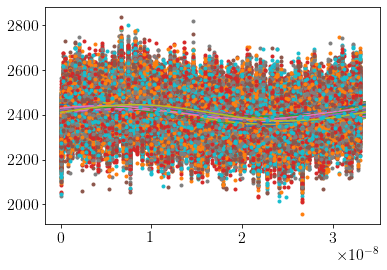

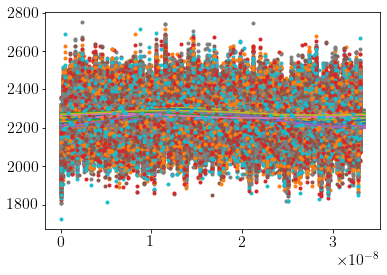

In [27]:
# plot fitu vcetne errorbaru
# my_dpi = 150
# siz = 100
# sizex = 16*siz
# sizey = 9*siz
# plot techto fitu

time_fit = np.linspace(0, t_scale.max(), 200)
plt.figure()
ax = plt.gca()

plt.figure(2)
ax2 = plt.gca()

ax_list = [ax, ax2]

for k in range(N):

    
    for i in range(fotkor_shape[1]):

        fotkor_fit = fit_func(x_rand[k,i,:], Omega, time_fit)

        
#         ax.errorbar(t_scale[:fotkor_shape[0]-2],fotkor[:fotkor_shape[0]-2,i],yerr=1/np.sqrt(hist_sigma[i]),fmt='.')
        ax_list[i].plot(time_fit, fotkor_fit)
        ax_list[i].plot(t_scale[:fotkor_shape[0]-2],fotkor_rand_save[k,:fotkor_shape[0]-2,i], '.')
#         text = r'$\frac{\Delta S}{S_0}  = \,\,$' + r'${:.5f} $'.format(x[1,i]/x[0,i])
#         plt.text(3e-8, fotkor[:,i].max()-500,text) 
#         text2 = r'$\varphi  = {:.5f}$'.format(fot_phi[i])
#         plt.text(3e-8, fotkor[:,i].max()-100,text2)
    #     text = r'$\frac{\Delta S}{S_0}  = \,\,$' + r'${:.5f} \pm {:.6f}$'.format(x[1,i]/x[0,i], Delta_S_S_ratio_sigma[i])
    #     plt.text(3e-8, fotkor[:,i].max()-500,text) 
#     text2 = r'$\varphi  = {:.5f} \pm {:.3}$'.format(fot_phi[i], sigmas[2,i])
#     plt.text(3e-8, fotkor[:,i].max(),text2) 
